In [12]:
from sim.system_models.vehicle_systems.tire_model import TireModel
from sim.model_parameters.cars.lady_luck import LadyLuck

In [13]:
tire_model = TireModel()
lady_luck = LadyLuck()
tire_model.lat_coeffs = lady_luck.rear_tire_coeff_Fy
tire_model.long_coeffs = lady_luck.rear_tire_coeff_Fx

print(tire_model._get_comstock_forces(SR = 0, SA = 5, FZ = 1200, IA = 0.01745))

[8.095425804289728e-62, 2454.65647530287, 1200]


In [14]:
from sim.system_models.vehicle_systems.suspension_model import SuspensionModel

from sim.model_parameters.cars.lady_luck import LadyLuck
from sim.system_models.vectors.controls_vector import ControlsVector
from sim.system_models.vectors.observables_vector import ObservablesVector
from sim.system_models.vectors.state_vector import StateVector
from sim.system_models.vectors.state_dot_vector import StateDotVector

import numpy as np

from scipy.optimize import fsolve

import matplotlib.pyplot as plt

import pandas as pd

new_model = SuspensionModel()
test_car = LadyLuck()
test_controls_vector = ControlsVector()
test_state_vector = StateVector()
test_state_dot_vector = StateDotVector()
test_observables_vector = ObservablesVector()

In [15]:
def vehicle_model(x, y):
    # Prescribed values
    test_state_vector.body_slip = y[0]
    test_state_vector.velocity = y[1]
    test_controls_vector.steering_angle = y[2]

    # Iterated values
    test_state_vector.long_accel = x[0]
    test_state_vector.lateral_accel = x[1]
    test_state_vector.yaw_accel = x[2]
    test_state_vector.heave = x[3]
    test_state_vector.pitch = x[4]
    test_state_vector.roll = x[5]

    new_model.eval(vehicle_parameters = test_car, controls_vector = test_controls_vector, state_vector = test_state_vector, 
               state_dot_vector = test_state_dot_vector, observables_vector = test_observables_vector)

    return [*test_observables_vector.summation_forces, *test_observables_vector.summation_moments]

In [16]:
mesh = 31

sweep_range = {"body_slip": (-10 * np.pi / 180, 10 * np.pi / 180),
        "steered_angle" : (-90 * np.pi / 180, 90 * np.pi / 180),
        "velocity" : (25)}

body_slip_sweep = np.linspace(sweep_range["body_slip"][0], sweep_range["body_slip"][1], mesh)
steered_angle_sweep = np.linspace(sweep_range["steered_angle"][0], sweep_range["steered_angle"][1], mesh)

long_accels = []
lat_accels = []
yaw_accels = []
heaves = []
pitches = []
rolls = []
body_slips = []
velocities = []
steered_angles = []
normal_loads = []
slip_angles = []
inclination_angles = []
raw_tire_forces = []

for body_slip in body_slip_sweep:
    for steered_angle in steered_angle_sweep:
        for velocity in [25]:
            try:
                setup_func = lambda x: vehicle_model(x, [body_slip, velocity, steered_angle])

                fsolve_results = fsolve(setup_func, [0, 0, 0, 0, 0, 0], maxfev = 1000)

                long_accels.append(fsolve_results[0])
                lat_accels.append(fsolve_results[1])
                yaw_accels.append(fsolve_results[2])
                heaves.append(fsolve_results[3])
                pitches.append(fsolve_results[4])
                rolls.append(fsolve_results[5])
                body_slips.append(body_slip)
                velocities.append(velocity)
                steered_angles.append(steered_angle)

                vehicle_model(fsolve_results, [body_slip, velocity, steered_angle])

                normal_loads.append(test_observables_vector.normal_loads)
                slip_angles.append(test_observables_vector.slip_angles)
                inclination_angles.append(test_observables_vector.inclination_angles)
                raw_tire_forces.append(test_observables_vector.raw_tire_forces)

            except:
                continue
        pass
    pass

In [17]:
print(max(lat_accels))
print(min(lat_accels))
print(max(yaw_accels))
print(min(yaw_accels))

19.777430437795708
-20.599196969553972
36.99571043456903
-37.1781231266365


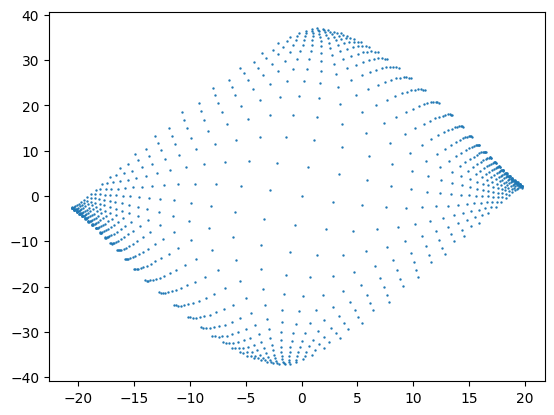

In [18]:
plt.scatter(lat_accels, yaw_accels, s=0.5)
# plt.xlim(-25, 25)
# plt.ylim(-30, 30)

In [19]:
df = pd.DataFrame()

# df['long_accel'] = long_accels
# df['lat_accel'] = lat_accels
df['heave'] = heaves
df['pitch'] = pitches
df['roll'] = rolls
# df['body_slip'] = body_slips
# df['velocity'] = velocities
# df['steered_angle'] = steered_angles

df['front_left_FZ'] = [x[0] for x in normal_loads]
df['front_right_FZ'] = [x[1] for x in normal_loads]
df['rear_left_FZ'] = [x[2] for x in normal_loads]
df['rear_right_FZ'] = [x[3] for x in normal_loads]

# df['front_left_slip_angle'] = [x[0] for x in slip_angles]
# df['front_right_slip_angle'] = [x[1] for x in slip_angles]
# df['rear_left_slip_angle'] = [x[2] for x in slip_angles]
# df['rear_right_slip_angle'] = [x[3] for x in slip_angles]

# df['front_left_IA'] = [x[0] for x in inclination_angles]
# df['front_right_IA'] = [x[1] for x in inclination_angles]
# df['rear_left_IA'] = [x[2] for x in inclination_angles]
# df['rear_right_IA'] = [x[3] for x in inclination_angles]

# df['front_left_tire_forces'] = [x[0] for x in raw_tire_forces]
# df['front_right_tire_forces'] = [x[1] for x in raw_tire_forces]
# df['rear_left_tire_forces'] = [x[2] for x in raw_tire_forces]
# df['rear_right_tire_forces'] = [x[3] for x in raw_tire_forces]
df['yaw_accel'] = yaw_accels

df.to_csv("output.csv")

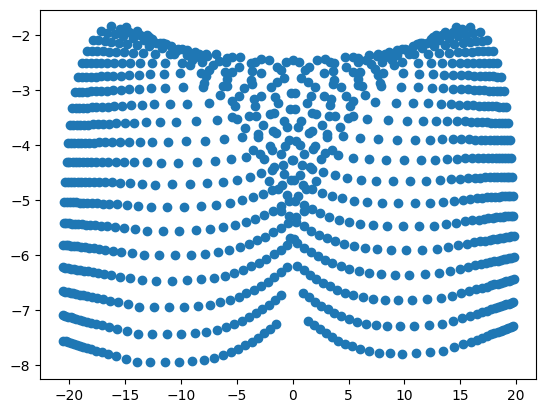

In [20]:
plt.scatter(lat_accels, long_accels)